---
# Convolutional Neural Networks

In this assignment, you will first implement the forward and backward pass of a convolution layer. Then you can freely design your own CNN model for image classification on CIFAR-10.

As in previous assignments, you will see code blocks that look like this:
```python
###############################################################################
# TODO: Create a variable x with value 536.                                   #
###############################################################################
# Replace "pass" statement with your code
pass
# END OF YOUR CODE
```

You should replace the `pass` statement with your own code and leave the blocks intact, like this:
```python
###############################################################################
# TODO: Create a variable x with value 536.                                   #
###############################################################################
# Replace "pass" statement with your code
x = 536
# END OF YOUR CODE
```

Also, please remember:
- Do not write or modify any code outside of code blocks unless otherwise stated.
- Do not delete any cells from the notebook. You may add new cells to perform scratch work, but delete them before submitting.
- Run all cells before submitting. You will only get credit for code that has been run.
- Submit your notebook as `netid.ipynb`, where `netid` is your actual netid.
- Your submission will be graded with PyTorch 1.7.0 and Python 3.6, which are the default versions in Google Colab.

In [ ]:
from __future__ import print_function
from __future__ import division

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import random_split, DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [ ]:
assert torch.cuda.is_available(), 'GPU unavailable'

## Convolution - Forward Pass

Let us first implement the forward pass of 2D convolution and get a better understanding of the operations it performs. We will be replicating the functionality of PyTorch's built-in 2D convolution: [`nn.Conv2d()`](https://pytorch.org/docs/1.7.0/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) and [`F.conv2d()`](https://pytorch.org/docs/1.7.0/nn.functional.html#torch.nn.functional.conv2d). Please refer to the documentation for more details of the input arguments and return values. It is acceptable to use nested loops here, but you may also develop a vectorized implementation.

In [ ]:
def conv2d(input, weight, bias=None, stride=1, padding=0):
  """
  Apply 2D convolution over a batch of input tensors.
  
  Input arguments and return value are the same as those of F.conv2d(),
  except that we don't care about `dilation` and `groups` here.
  Also, `padding_mode` is `zeros`.
  """
  output = None
  #############################################################################
  # TODO: Implement the same functionality as F.conv2d(). You are NOT allowed #
  # to use F.conv2d() or nn.Conv2d().                                         #
  #############################################################################
  # Replace "pass" statement with your code
  if type(padding) == tuple:
    ph = padding[0]
    pw = padding[1]
    pad2= (padding[1], padding[1], padding[0], padding[0])
  else:
    ph = padding
    pw = padding
    pad2= (padding, padding, padding, padding)

  if type(stride) == tuple:
    sh = stride[0]
    sw = stride[1]
  else:
    sh = stride
    sw = stride
    
  padded = torch.nn.functional.pad(input, pad2, "constant", 0)

  N, C, H, W = input.shape 
  F, _, H2, W2 = weight.shape 

  HN = int(1 + (H + 2*ph - H2)/sh) 
  WN = int(1 + (W + 2*pw - W2)/sw)
  output = torch.empty((N, F, HN, WN), dtype=torch.float64).to(input.device)
  if bias!=None:
    for n in range(N):
      for f in range(F):
        for i in range(0, HN):
          for j in range(0, WN):
            output[n][f][i][j] = torch.sum(weight[f, :, :, :]*padded[n, :, i*sh:i*sh+H2, j*sw:j*sw+W2])+ bias[f]

  else :
    for n in range(N):
      for f in range(F):
        for i in range(0, HN):
          for j in range(0, WN):
            output[n][f][i][j] = torch.sum(weight[f, :, :, :]*padded[n, :, i*sh:i*sh+H2, j*sw:j*sw+W2])
  
  # END OF YOUR CODE
  return output

We will use the following helper functions to check your results:

In [ ]:
def max_diff(actual, expected):
  return (actual - expected).abs().max().item()

In [ ]:
def check_conv2d(batch_size, in_channels, in_height, in_width,
                 out_channels, kernel_size, stride=1, padding=0, use_bias=True):
  
  if isinstance(kernel_size, int):
    kernel_size = (kernel_size, kernel_size)
  
  torch.manual_seed(0)
  input = torch.empty(batch_size, in_channels, in_height, in_width).normal_()
  weight = torch.empty(out_channels, in_channels, kernel_size[0], kernel_size[1]).normal_()
  if use_bias:
    bias = torch.empty(out_channels).normal_()
  else:
    bias = None
  
  actual = conv2d(input, weight, bias, stride, padding)
  expected = F.conv2d(input, weight, bias, stride, padding)
  assert actual.shape == expected.shape, 'incorrect shape'
  
  diff = max_diff(actual, expected)
  print('max_diff = %e' % diff)
  assert diff < 1e-3, 'incorrect result'

In [ ]:
# check `kernel_size`
check_conv2d(batch_size=8, in_channels=3, in_height=8, in_width=8,
             out_channels=8, kernel_size=3, stride=1, padding=0, use_bias=True)

max_diff = 3.814697e-06


In [ ]:
# check `stride`
check_conv2d(batch_size=4, in_channels=8, in_height=16, in_width=16,
             out_channels=3, kernel_size=5, stride=3, padding=0, use_bias=True)

max_diff = 1.335144e-05


In [ ]:
# check `padding`
check_conv2d(batch_size=1, in_channels=1, in_height=32, in_width=32,
             out_channels=4, kernel_size=8, stride=5, padding=3, use_bias=True)

max_diff = 5.722046e-06


In [ ]:
# check tuple arguments
check_conv2d(batch_size=16, in_channels=4, in_height=4, in_width=8,
             out_channels=1, kernel_size=(1, 3), stride=(1, 2), padding=(0, 1), use_bias=False)

max_diff = 9.536743e-07


## Convolution - Backward Pass

In order to train a CNN, we need to backpropagate the gradient through the convolution. More precisely, suppose we have performed a convolution:
$$
\text{output} = \text{conv2d}(\text{input}, \text{weight}, \text{bias}),
$$
and the loss is defined as some function of the output:
$$
\mathcal{L} = f(\text{output}).
$$
Note that $\text{output}, \text{input}, \text{weight}, \text{bias}$ are tensors, and $\mathcal{L}$ is a scalar.

We need the gradients $\frac{\partial \mathcal{L}}{\partial \text{weight}}$ and $\frac{\partial \mathcal{L}}{\partial \text{bias}}$, which can be computed by the chain rule:
$$
\begin{align}
\frac{\partial \mathcal{L}}{\partial \text{weight}_i} &= \sum_{k} \frac{\partial \mathcal{L}}{\partial \text{output}_k} \frac{\partial \text{output}_k}{\partial \text{weight}_i},\\
\frac{\partial \mathcal{L}}{\partial \text{bias}_j} &= \sum_{k} \frac{\partial \mathcal{L}}{\partial \text{output}_k} \frac{\partial \text{output}_k}{\partial \text{bias}_j}.
\end{align}
$$
If $\text{input}$ is computed by another neural network with parameters $\theta$, then to obtain $\frac{\partial \mathcal{L}}{\partial \theta}$, we also need $\frac{\partial \mathcal{L}}{\partial \text{input}}$.

Therefore, in the backward pass that we will implement below, given $\frac{\partial \mathcal{L}}{\partial \text{output}}$, we need to compute $\frac{\partial \mathcal{L}}{\partial \text{input}}$, $\frac{\partial \mathcal{L}}{\partial \text{weight}}$, and $\frac{\partial \mathcal{L}}{\partial \text{bias}}$.

You are NOT allowed to use PyTorch's automatic differentiation, but you may use other built-in functions (in particular, [`F.conv2d()`](https://pytorch.org/docs/1.7.0/nn.functional.html#torch.nn.functional.conv2d) and [`F.conv_transpose2d()`](https://pytorch.org/docs/1.7.0/nn.functional.html#torch.nn.functional.conv_transpose2d)) if they can simplify your implementation. For simplicity, you only need to consider the case where `stride = 1`. You will get bonus points if your implementation also works for `stride > 1`.

In [ ]:
def conv2d_grad(output_grad, input, weight, bias=None, stride=1, padding=0):
  """
  Backward pass of 2D convolution.
  
  Inputs:
  - output_grad: A PyTorch tensor giving the gradient of loss wrt `output`
    computed by the forward pass conv2d(). It has the same shape as `output`.
  - Other arguments are the same as those of conv2d().
  
  Returns:
  - input_grad: A PyTorch tensor giving the gradient of loss wrt `input`.
    It has the same shape as `input`.
  - weight_grad: A PyTorch tensor giving the gradient of loss wrt `weight`.
    It has the same shape as `weight`.
  - bias_grad: A PyTorch tensor giving the gradient of loss wrt `bias`.
    It has the same shape as `bias` if `bias` is not `None`.
    Otherwise, it is `None`.
  """
  input_grad = None
  weight_grad = None
  bias_grad = None
  #############################################################################
  # TODO: Implement the backward pass of conv2d(). You are NOT allowed to use #
  # PyTorch's automatic differentiation.                                      #
  #############################################################################
  # Replace "pass" statement with your code

  if type(padding) == tuple:
    ph = padding[0]
    pw = padding[1]
    pad2= (padding[1], padding[1], padding[0], padding[0])
  else:
    ph = padding
    pw = padding
    pad2= (padding, padding, padding, padding)

  if type(stride) == tuple:
    sh = stride[0]
    sw = stride[1]
  else:
    sh = stride
    sw = stride

  padded = torch.nn.functional.pad(input, pad2, "constant", 0)

  N, C, H, W = input.shape 
  F, _, HH, WW = weight.shape 

  H2 = int(1 + (H + 2*ph - HH)/sh) 
  W2 = int(1 + (W + 2*pw - WW)/sw)

  acum_dw = torch.zeros_like(weight)
  acum_dpadded = torch.zeros_like(padded)
  acum_db = torch.zeros_like(bias) 
  for n in range(N):
    for f in range(F):
      acum_db[f] += torch.sum(output_grad[n][f])
      for i in range(0, H2):
        for j in range(0, W2):
          acum_dw[f] += padded[n, :, i*sh:i*sh+HH, j*sw:j*sw+WW] * output_grad[n, f, i, j]
          acum_dpadded[n, :, i*sh:i*sh+HH, j*sw:j*sw+WW] += weight[f]* output_grad[n, f, i, j]
  weight_grad = acum_dw 
  input_grad = acum_dpadded[:,:,ph:ph+H,pw:pw+W]
  bias_grad = acum_db 
  

  # END OF YOUR CODE
  return input_grad, weight_grad, bias_grad

To check correctness, let us define a simple loss function:
$$
\mathcal{L} = f(\text{output}) = \sum_k \text{output}_k,
$$
so that for each element in the output,
$$
\frac{\partial \mathcal{L}}{\partial \text{output}_k} = 1.
$$
Hence, we can use a tensor of ones for `output_grad`.

We will compare the returned gradients with those computed by PyTorch's automatic differentiation. To use automatic differentiation:
- Create tensors with `requires_grad=True`. PyTorch will automatically build up a computational graph of operations involving those tensors.
- Compute the loss (forward pass).
- Call `loss.backward()`. PyTorch will use backpropagation to compute the gradient of the loss wrt the tensors in the computational graph. The gradient is stored in the `.grad` attribute of each tensor.

We will use the following helper functions to check your results:

In [ ]:
def max_rel_error(actual, expected):
  
  rel_error_top = (actual - expected).abs()
  rel_error_bot = actual.abs() + expected.abs() + 1e-7
  return (rel_error_top / rel_error_bot).max().item()

In [ ]:
def check_conv2d_grad(batch_size, in_channels, in_height, in_width,
                      out_channels, kernel_size, stride=1, padding=0, use_bias=True,
                      variable='input'):
  
  if isinstance(kernel_size, int):
    kernel_size = (kernel_size, kernel_size)
  
  torch.manual_seed(0)
  input = torch.empty(batch_size, in_channels, in_height, in_width).normal_()
  weight = torch.empty(out_channels, in_channels, kernel_size[0], kernel_size[1]).normal_()
  if use_bias:
    bias = torch.empty(out_channels).normal_()
  else:
    bias = None
  
  output = F.conv2d(input, weight, bias, stride, padding)
  output_grad = torch.ones_like(output)
  
  input_grad, weight_grad, bias_grad = conv2d_grad(
    output_grad, input, weight, bias, stride, padding)
  
  # Use automatic differentiation to compute gradients
  # 1. Set `requires_grad` to `True`
  input.requires_grad_()
  weight.requires_grad_()
  if use_bias:
    bias.requires_grad_()
  
  # 2. Compute loss
  output = F.conv2d(input, weight, bias, stride, padding)
  loss = output.sum()
  
  # 3. Backpropagation
  loss.backward()
  # The gradients are stored in `input.grad`, `weight.grad`, and `bias.grad`
  
  if variable == 'input':
    assert input_grad.shape == input.grad.shape, 'incorrect shape'
    rel_error = max_rel_error(input_grad, input.grad)
    print('relative error = %e' % rel_error)
    assert rel_error < 1e-3, 'incorrect result'
  elif variable == 'weight':
    assert weight_grad.shape == weight.grad.shape, 'incorrect shape'
    rel_error = max_rel_error(weight_grad, weight.grad)
    print('relative error = %e' % rel_error)
    assert rel_error < 1e-3, 'incorrect result'
  else:
    if not use_bias:
      assert bias_grad is None
    else:
      assert bias_grad.shape == bias.grad.shape, 'incorrect shape'
      rel_error = max_rel_error(bias_grad, bias.grad)
      print('relative error = %e' % rel_error)
      assert rel_error < 1e-3, 'incorrect result'

In [ ]:
# check `kernel_size`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=8, in_width=8,
                  out_channels=1, kernel_size=3, stride=1, padding=0, use_bias=True,
                  variable='input')

relative error = 6.217231e-07


In [ ]:
# check `kernel_size`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=8, in_width=8,
                  out_channels=1, kernel_size=3, stride=1, padding=0, use_bias=True,
                  variable='weight')

relative error = 1.121814e-07


In [ ]:
# check `kernel_size`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=8, in_width=8,
                  out_channels=1, kernel_size=3, stride=1, padding=0, use_bias=True,
                  variable='bias')

relative error = 0.000000e+00


In [ ]:
# check `padding`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=32, in_width=32,
                  out_channels=1, kernel_size=8, stride=1, padding=3, use_bias=True,
                  variable='input')

relative error = 4.184267e-07


In [ ]:
# check `padding`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=32, in_width=32,
                  out_channels=1, kernel_size=8, stride=1, padding=3, use_bias=True,
                  variable='weight')

relative error = 0.000000e+00


In [ ]:
# check `padding`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=32, in_width=32,
                  out_channels=1, kernel_size=8, stride=1, padding=3, use_bias=True,
                  variable='bias')

relative error = 0.000000e+00


In [ ]:
# check `in_channels`
check_conv2d_grad(batch_size=1, in_channels=8, in_height=8, in_width=8,
                  out_channels=1, kernel_size=1, stride=1, padding=0, use_bias=True,
                  variable='input')

relative error = 0.000000e+00


In [ ]:
# check `in_channels`
check_conv2d_grad(batch_size=1, in_channels=8, in_height=8, in_width=8,
                  out_channels=1, kernel_size=1, stride=1, padding=0, use_bias=True,
                  variable='weight')

relative error = 1.820473e-07


In [ ]:
# check `in_channels`
check_conv2d_grad(batch_size=1, in_channels=8, in_height=8, in_width=8,
                  out_channels=1, kernel_size=1, stride=1, padding=0, use_bias=True,
                  variable='bias')

relative error = 0.000000e+00


In [ ]:
# check `out_channels`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=32, in_width=32,
                  out_channels=2, kernel_size=9, stride=1, padding=2, use_bias=True,
                  variable='input')

relative error = 3.272701e-06


In [ ]:
# check `out_channels`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=32, in_width=32,
                  out_channels=2, kernel_size=9, stride=1, padding=2, use_bias=True,
                  variable='weight')

relative error = 0.000000e+00


In [ ]:
# check `out_channels`
check_conv2d_grad(batch_size=1, in_channels=1, in_height=32, in_width=32,
                  out_channels=2, kernel_size=9, stride=1, padding=2, use_bias=True,
                  variable='bias')

relative error = 0.000000e+00


In [ ]:
# check `batch_size`
check_conv2d_grad(batch_size=8, in_channels=1, in_height=16, in_width=16,
                  out_channels=1, kernel_size=5, stride=1, padding=3, use_bias=True,
                  variable='input')

relative error = 1.685663e-07


In [ ]:
# check `batch_size`
check_conv2d_grad(batch_size=8, in_channels=1, in_height=16, in_width=16,
                  out_channels=1, kernel_size=5, stride=1, padding=3, use_bias=True,
                  variable='weight')

relative error = 0.000000e+00


In [ ]:
# check `batch_size`
check_conv2d_grad(batch_size=8, in_channels=1, in_height=16, in_width=16,
                  out_channels=1, kernel_size=5, stride=1, padding=3, use_bias=True,
                  variable='bias')

relative error = 0.000000e+00


In [ ]:
# check tuple arguments
check_conv2d_grad(batch_size=16, in_channels=4, in_height=4, in_width=8,
                  out_channels=8, kernel_size=(1, 3), stride=1, padding=1, use_bias=True,
                  variable='input')

relative error = 7.630093e-07


In [ ]:
# check tuple arguments
check_conv2d_grad(batch_size=16, in_channels=4, in_height=4, in_width=8,
                  out_channels=8, kernel_size=(1, 3), stride=1, padding=1, use_bias=True,
                  variable='weight')

relative error = 1.586823e-05


In [ ]:
# check tuple arguments
check_conv2d_grad(batch_size=16, in_channels=4, in_height=4, in_width=8,
                  out_channels=8, kernel_size=(1, 3), stride=1, padding=1, use_bias=True,
                  variable='bias')

relative error = 0.000000e+00


BONUS: `stride > 1`:

In [ ]:
# check `stride`
check_conv2d_grad(batch_size=16, in_channels=4, in_height=4, in_width=8,
                  out_channels=8, kernel_size=(1, 3), stride=(1, 2), padding=1, use_bias=True,
                  variable='input')

relative error = 3.424135e-07


In [ ]:
# check `stride`
check_conv2d_grad(batch_size=16, in_channels=4, in_height=4, in_width=8,
                  out_channels=8, kernel_size=(1, 3), stride=(1, 2), padding=1, use_bias=True,
                  variable='weight')

relative error = 2.700911e-06


## CIFAR-10 Open-Ended Challenge

In this section, you can experiment with whatever CNN architecture you'd like on CIFAR-10. Your model should be able to **achieve at least 75% validation accuracy** within 10-20 epochs.

This [tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) will walk you through the process of training a CNN classifier using PyTorch. The model used in this tutorial, however, is too simple for our purpose. To conveniently create a deeper model, you can use [`nn.Sequential()`](https://pytorch.org/docs/1.7.0/generated/torch.nn.Sequential.html#torch.nn.Sequential) to stack multiple layers together. You can use built-in layers in the [`torch.nn`](https://pytorch.org/docs/1.7.0/nn.html) package, or you can develop custom layers. All custom layers should subclass [`nn.Module`](https://pytorch.org/docs/1.7.0/generated/torch.nn.Module.html#torch.nn.Module).

### Things you might try
- **Network architecture**: [VGG](https://arxiv.org/abs/1409.1556) can be a good starting point. Keep in mind that this model is designed for ImageNet, which is much larger and have a different image resolution than CIFAR-10. You need to make some adaptations. For example, you may tweak the number of layers and number of channels. [ResNet](https://arxiv.org/abs/1512.03385) and [DenseNet](https://arxiv.org/abs/1608.06993) are also good architectures to try.
- **Batch normalization**: You can conveniently add batch normalization layers using [`nn.BatchNorm2d()`](https://pytorch.org/docs/1.7.0/generated/torch.nn.BatchNorm2d.html#torch.nn.BatchNorm2d). Does your model train faster with batch normalization?
- **Optimizer**: The [`torch.optim`](https://pytorch.org/docs/1.7.0/optim.html) package implements many optimization algorithms that you can try, such as [SGD](https://pytorch.org/docs/1.7.0/optim.html#torch.optim.SGD), [Adam](https://pytorch.org/docs/1.7.0/optim.html#torch.optim.Adam), and [RMSprop](https://pytorch.org/docs/1.7.0/optim.html#torch.optim.RMSprop).
- **Regularization**: You may use weight decay or [Dropout](https://pytorch.org/docs/1.7.0/generated/torch.nn.Dropout.html#torch.nn.Dropout) to reduce overfitting.
- **Activation**: In addition to [ReLU](https://pytorch.org/docs/1.7.0/generated/torch.nn.ReLU.html#torch.nn.ReLU), some recent papers also use [ELU](https://pytorch.org/docs/1.7.0/generated/torch.nn.ELU.html#torch.nn.ELU) and [GELU](https://pytorch.org/docs/1.7.0/generated/torch.nn.GELU.html#torch.nn.GELU). Can they improve your model's performance?
- **Pooling vs Strided Convolution**: Similar to pooling, strided convolution can reduce the spatial size of feature maps. However, strided convolution contains learnable parameters, which make the model more flexible. Does strided convolution lead to improved performance?
- **Flattening vs Global Average Pooling**: [GoogLeNet](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/43022.pdf), [ResNet](https://arxiv.org/abs/1512.03385), and [DenseNet](https://arxiv.org/abs/1608.06993) all use global average pooling followed by a single linear layer to produce the class probabilities from the last feature map. How does this compare to the traditional approach of flattening the last feature map and then having several fully connected layers?

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters using the validation set. Remember the coarse-to-fine strategy.

### Have fun and happy training!

### Data Preprocessing

We will use the precomputed RGB mean and standard deviation to normalize the images. We then use PyTorch's built-in [`DataLoader`](https://pytorch.org/docs/1.7.0/data.html#torch.utils.data.DataLoader) for automatic mini-batch sampling.

In [ ]:
def get_data_loaders():
  """
  Normalize the data and split into (train 40K)/(val 10K)/(test 10K).
  
  Returns:
  - PyTorch DataLoaders that can automatically sample mini-batches.
  """
  loader_kwargs = {
    'batch_size': 100,
    'shuffle': True,
    'num_workers': 4,
    'pin_memory': True,
    'drop_last': True,
  }
  
  transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
  ])
  
  CIFAR10_train = CIFAR10(root='.', train=True, transform=transform, download=True)
  CIFAR10_test = CIFAR10(root='.', train=False, transform=transform, download=True)
  
  train_set, val_set = random_split(CIFAR10_train, [40000, 10000],
                                    generator=torch.Generator().manual_seed(0))
  
  train_loader = DataLoader(train_set, **loader_kwargs)
  val_loader = DataLoader(val_set, **loader_kwargs)
  test_loader = DataLoader(CIFAR10_test, **loader_kwargs)
  
  return train_loader, val_loader, test_loader

### Model

Implement your CNN model below. If you implemented multiple models, you only need to show the best one. You may add helper functions and custom modules as necessary.

In [ ]:
class Net(nn.Module):
  
  def __init__(self):
    super().__init__()
    #########################################################################
    # TODO:                                                                 #
    # Specify your model architecture.                                      #
    #########################################################################
    # Replace "pass" statement with your code
    self.conv_layer = nn.Sequential(

            
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(p=0.05),

           
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )


    self.fc_layer = nn.Sequential(
        nn.Dropout(p=0.1),
        nn.Linear(4096, 1024),
        nn.ReLU(inplace=True),
        nn.Linear(1024, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(p=0.1),
        nn.Linear(512, 10)
    )
    # END OF YOUR CODE
  
  
  def forward(self, images, labels):
    """
    Compute the loss for a mini-batch of training samples.
    
    Inputs:
    - images: A PyTorch tensor of shape (B, 3, 32, 32) containing
      a mini-batch of B training images.
    - labels: A PyTorch tensor of shape (B,) containing the corresponding
      training labels; labels[i] = k means that images[i] has label k,
      where 0 <= k < 10.
    
    Returns:
    - loss: A PyTorch scalar giving the training loss of this mini-batch.
    """
    loss = None
    #########################################################################
    # TODO:                                                                 #
    # Implement the forward pass.                                           #
    #########################################################################
    # Replace "pass" statement with your code
    images = self.conv_layer(images)
    images = images.view(images.size(0), -1)
    images = self.fc_layer(images)
    criterion = nn.CrossEntropyLoss()
    loss= criterion(images , labels)
    # END OF YOUR CODE
    return loss
  
  
  def predict(self, images):
    """
    Predict the labels for a mini-batch of images.
    
    Inputs:
    - images: A PyTorch tensor of shape (B, 3, 32, 32) containing
      a mini-batch of B images.
    
    Returns:
    - labels_pred: A PyTorch tensor of shape (B,) containing the predicted
      labels; labels_pred[i] = k means that k is the predicted label for
      images[i], where 0 <= k < 10.
    """
    labels_pred = None
    #########################################################################
    # TODO:                                                                 #
    # Implement the prediction phase.                                       #
    #########################################################################
    # Replace "pass" statement with your code
    images = self.conv_layer(images)
    images = images.view(images.size(0), -1)
    images = self.fc_layer(images)
    _, labels_pred = torch.max(images, dim=1)
    # END OF YOUR CODE
    return labels_pred

## Evaluation

We will use the following function to evaluate the classification accuracy:

In [ ]:
def eval_acc(model, data_loader):
  
  with torch.no_grad():
    model.eval()
    
    total = 0
    correct = 0
    
    for (images, labels) in data_loader:
      images = images.cuda()
      labels = labels.cuda()
      
      labels_pred = model.predict(images)
      
      total += labels.shape[0]
      correct += (labels_pred == labels).sum().item()
    
    acc = 100 * correct / total
  
  return acc

## Training

A basic training script is provided below. You can make modifications as appropriate. For example, you can save the model that achieves the best validation accuracy (instead of always using the latest model). Also, you may use learning rate schedules and gradient clipping. Only keep the best hyperparameters that you found.

In [ ]:
import torch.optim as optim


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train Epoch:   0 	 Loss: 2.311171 	 Val Acc: 10.050000
Train Epoch:   1 	 Loss: 1.708897 	 Val Acc: 39.170000
Train Epoch:   2 	 Loss: 1.411922 	 Val Acc: 50.470000
Train Epoch:   3 	 Loss: 1.137425 	 Val Acc: 59.120000
Train Epoch:   4 	 Loss: 0.970808 	 Val Acc: 64.970000
Train Epoch:   5 	 Loss: 0.679499 	 Val Acc: 69.010000
Train Epoch:   6 	 Loss: 0.708595 	 Val Acc: 69.000000
Train Epoch:   7 	 Loss: 0.721644 	 Val Acc: 73.560000
Train Epoch:   8 	 Loss: 0.570803 	 Val Acc: 74.010000
Train Epoch:   9 	 Loss: 0.653926 	 Val Acc: 75.440000


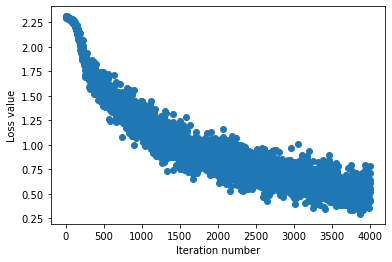

In [ ]:
train_loader, val_loader, test_loader = get_data_loaders()

torch.manual_seed(0)
model = Net()
model = model.cuda()

num_epochs = 10
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  # TODO: choose an optimizer

loss_history = []
for epoch in range(num_epochs):
  val_acc = eval_acc(model, val_loader)
  
  model.train()
  
  for batch, (images, labels) in enumerate(train_loader):
    images = images.cuda()
    labels = labels.cuda()
    
    optimizer.zero_grad()
    loss = model(images, labels)
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
      loss_history.append(loss.item())
      if batch == 0:
        print('Train Epoch: {:3} \t Loss: {:F} \t Val Acc: {:F}'.format(
          epoch, loss.item(), val_acc))

with torch.no_grad():
  plt.plot(loss_history, 'o')
  plt.xlabel('Iteration number')
  plt.ylabel('Loss value')
  plt.show()

## Results

In [ ]:
train_acc = eval_acc(model, train_loader)
print('Training Accuracy:', train_acc)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training Accuracy: 83.425


In [ ]:
val_acc = eval_acc(model, val_loader)
print('Validation Accuracy:', val_acc)
assert val_acc >= 75

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Validation Accuracy: 75.5


In [ ]:
test_acc = eval_acc(model, test_loader)
print('Test Accuracy:', test_acc)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Test Accuracy: 75.2
